In [1]:
#Connecting google Drive using auth
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Libraries
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

In [4]:
#Loading the training and test sets 
from distutils.dir_util import copy_tree


directory = '/content/drive/MyDrive/COVID-19 Radiography Database'

source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID']
input_dir = './train'
output_dir = './test'
root_dir = './train/covid19-radiography-database/COVID-19 Radiography Database'



if os.path.isdir(os.path.join(directory, source_dirs[1])):
    if not os.path.isdir(input_dir):
        os.mkdir(input_dir)
        copy_tree(directory, input_dir)
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
        
    for c in source_dirs:
        if not os.path.isdir(os.path.join(output_dir, c)):
            os.mkdir(os.path.join(output_dir, c))
            
    for c in source_dirs:
        images = [x for x in os.listdir(os.path.join(input_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 21)
        for image in selected_images:
            source_path = os.path.join(input_dir, c, image)
            target_path = os.path.join(output_dir, c, image)
            shutil.move(source_path, target_path)

In [5]:
# Changing the images to RGB format preping it up for training
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['Normal', 'Viral', 'COVID-19']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [6]:
#Creating a Transformation Object for augmentation
train_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(), #A RandomHorizontalFlip to augment our data
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

In [7]:
#Loading the augmented data into respective directories for training
train_dirs = {
    'Normal': input_dir + '/NORMAL',
    'Viral': input_dir + '/Viral Pneumonia',
    'COVID-19': input_dir + '/COVID'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1299 Normal examples
Found 1303 Viral examples
Found 1158 COVID-19 examples


In [8]:
#Creating a Transformation Object and loading augmented data into respective directories for testing
test_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(224,224)),
# We don't do data augmentation in the test/val set    
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

test_dirs = {
    'Normal': output_dir + '/NORMAL',
    'Viral': output_dir + '/Viral Pneumonia',
    'COVID-19': output_dir + '/COVID'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 42 Normal examples
Found 42 Viral examples
Found 42 COVID-19 examples


In [9]:
#preparation for training
batch_size = 6
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 627
Num of test batches 21


In [10]:
#some visuals
class_names = train_dataset.class_names

def show_images(images,labels, preds):
    plt.figure(figsize=(8,4))
    
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks =[]) # x & y ticks are set to blank
        image = image.numpy().transpose((1, 2, 0)) # Channel first then height and width
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

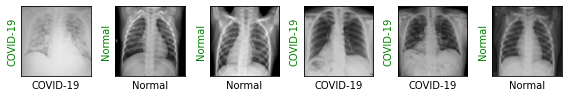

In [11]:
images, labels = next(iter(dl_train)) #Fetch the next batch of images
show_images(images, labels, labels)

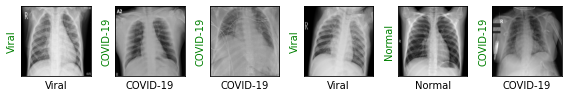

In [12]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [13]:
#loading the predefined reset18 CNN it has 18 layers this has been already trained on lot of images from imagenet database so it can be used to be enhanced with our images and provide better results
resnet18 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [14]:
#Changing the last fc to 3 output features - We are using the linear class of pytorch and in_feature is the number of inputs for linear layer which are 512 and out is going to be one of 3 here we are just setting the hyper paramerts of resnet

resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [15]:
def show_preds():
    resnet18.eval()  #Setting the model to evaluation mode
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

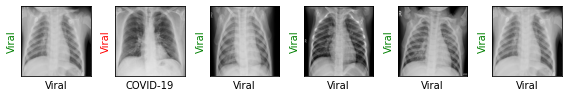

In [16]:
#this is resnet before to training and it seems to be not really doing a good job as expected
show_preds()

In [17]:
#actual training of  This is also Transfer learning where we are building on top of the already defined resnet18 CNN model we are using epoch 1 to be simple just one pass over entire dataset
#Here the training function will keep changing weights in the 18 layers till we reach an accuracy of >0.95
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.  #Not computing val_loss since we'll be evaluating the model multiple times within one epoch
        
        resnet18.train() # set model to training phase
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            #Once we get the loss we need to take a gradient step
            loss.backward() #Back propogation
            optimizer.step() #Completes the gradient step by updating all the parameter values(We are using all parameters)
            train_loss += loss.item() #Loss is a tensor which can't be added to train_loss so .item() converts it to float
            
            #Evaluating the model every 20th step
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1) # 1 corresponds to the values and ) corresponds to the no of examples
                    accuracy += sum((preds == labels).numpy()) #adding correct preds to acc

                val_loss /= (val_step + 1) # 15 test batches so this logic gives the value for each step
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.3954, Accuracy: 0.3413


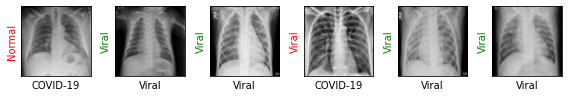

Evaluating at step 20
Validation Loss: 0.6737, Accuracy: 0.8651


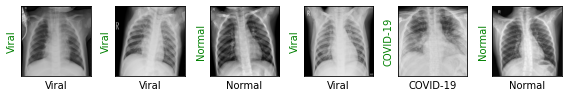

Evaluating at step 40
Validation Loss: 0.3057, Accuracy: 0.9524


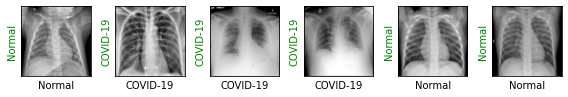

Performance condition satisfied, stopping..


In [18]:
#the actual training and model generation
train(epochs=1)

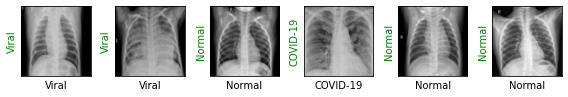

In [19]:
#We are now checking the same show predictions from before with dl_test and see really improved predictions
show_preds()

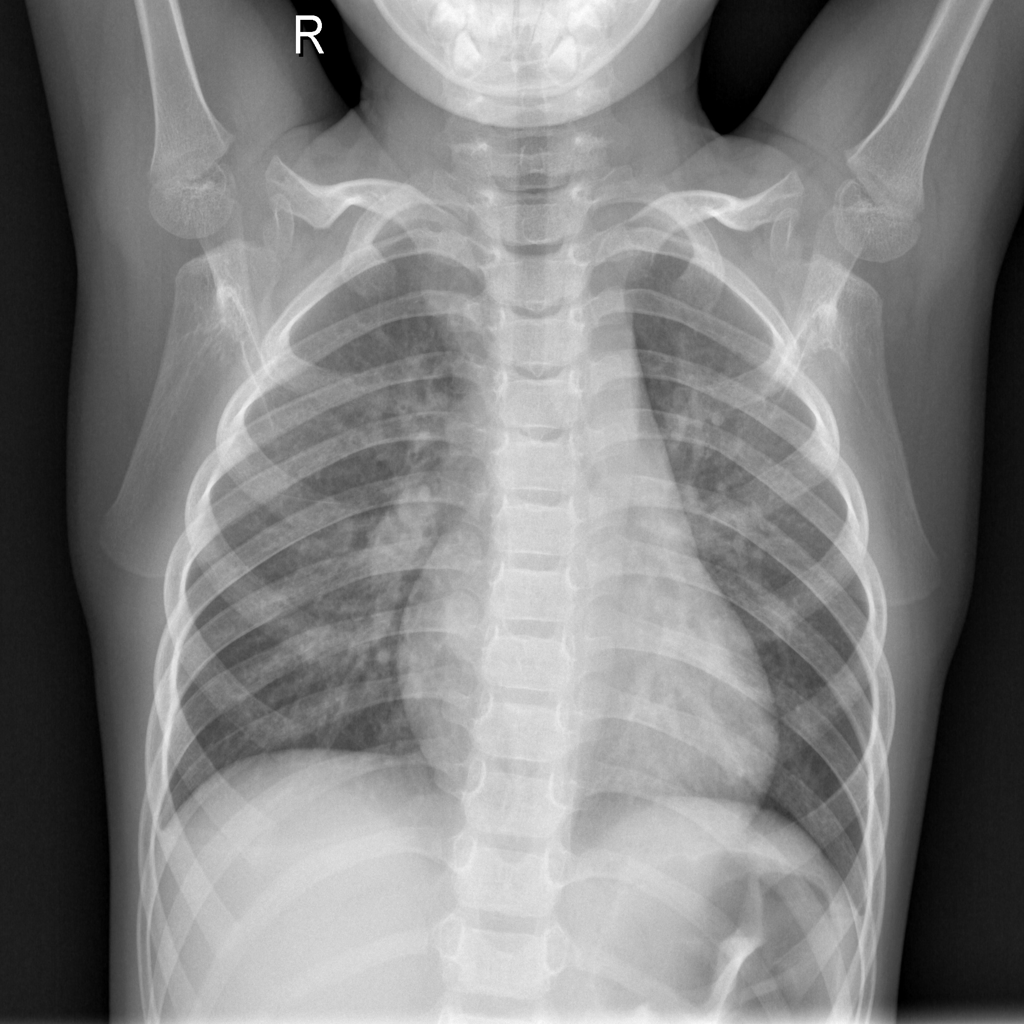

In [47]:
#Now we are going to take a random input data and do predictions
#loading image
from PIL import Image
#img_xray = Image.open(directory + "/COVID/COVID (1).png").convert('RGB')
#img_xray = Image.open(directory + "/Viral Pneumonia/Viral Pneumonia (1).png").convert('RGB')
img_xray = Image.open(directory + "/NORMAL/NORMAL (1).png").convert('RGB')
img_xray

In [48]:
#adding preprocessing for image and converting it into tensor which acts as a input to resnet18

from torchvision import transforms
#
# Create a preprocessing pipeline
#
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

img_xray_preprocessed = preprocess(img_xray)
batch_image_xray_tensor = torch.unsqueeze(img_xray_preprocessed, 0)


resnet18.eval()
out = resnet18(batch_image_xray_tensor)

_, preds = torch.max(out, 1)
class_names[int(preds)]

'Normal'

In [ ]:
#pickling the resnet model for future storage
import pickle
filename = 'resnet_pickle.pkl'
pickle.dump(resnet18, open(filename, 'wb'))

In [66]:
#Adding a custom method just to make predictions takes in image and provides result string
def predict(imagepath, model):
  from PIL import Image
  from torchvision import transforms
  image = Image.open(imagepath)
  img_xray = image.convert('RGB')
  preprocess = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225]
      )])
  img_xray_preprocessed = preprocess(img_xray)
  batch_image_xray_tensor = torch.unsqueeze(img_xray_preprocessed, 0)
  model.eval()
  out = model(batch_image_xray_tensor)
  _, preds = torch.max(out, 1)
  return class_names[int(preds)]

def load_model(pickleFile):
  model = pickle.load(open(pickleFile, "rb"))
  return model

#usage To call the model from API predict takes image and 
#Pls change directory as necessary
directory = '/content/drive/MyDrive/COVID-19 Radiography Database'

#predict(directory + "/COVID/COVID (1).png",load_model("resnet_pickle.pkl"))
#predict(directory + "/Viral Pneumonia/Viral Pneumonia (1).png",load_model("resnet_pickle.pkl"))
predict(directory + "/NORMAL/NORMAL (1).png",load_model("resnet_pickle.pkl"))



'Normal'